This notebook is meant to easily calculate the metrics for the best hyperparameters 

In [26]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import hashlib
import os
import datetime    
from datetime import timedelta
import utils 
import column_transforms
from sklearn.compose import ColumnTransformer
from importlib import reload

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

from shorten_filenames import shorten_filename

## Rolling window 

In [27]:

beginning_oos = end_validation = datetime.date(2017, 2, 28)
end_oos = datetime.date(2022, 3, 31)
beginning_validation = beginning_oos - timedelta(days=365*2)

df = pd.read_csv("features.csv", index_col=[0,1])
df.index = pd.MultiIndex.from_arrays(
    [pd.to_datetime(df.index.get_level_values(0)).date, df.index.get_level_values(1)]
)


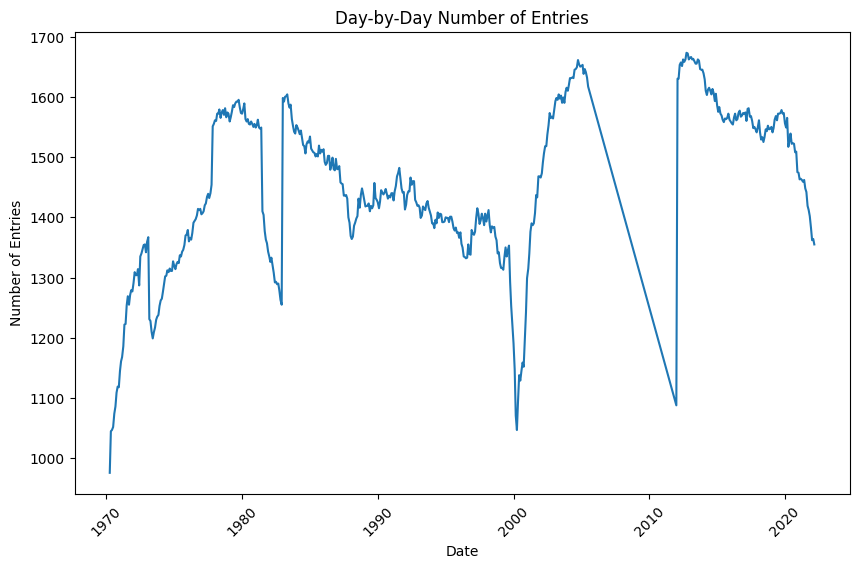

In [28]:
import matplotlib.pyplot as plt

# Count the number of entries per date
entry_counts = df.index.get_level_values(0).value_counts().sort_index()

# Plot the day-by-day number of entries
plt.figure(figsize=(10, 6))
plt.plot(entry_counts.index, entry_counts.values)
plt.xlabel('Date')
plt.ylabel('Number of Entries')
plt.title('Day-by-Day Number of Entries')
plt.xticks(rotation=45)
plt.show()


### XGBoost

In [29]:
reload(utils)

<module 'utils' from '/Users/mrityunjaisingh/dev_playground/test_230k/230K/utils.py'>

In [30]:

dates_index = pd.Series(df.loc[:end_validation, :].index.get_level_values(0).unique(), )
max_depth = 7
n_estimators = 5
reg_alpha = 0.020765
eta = 0.3023

accounting_ratios = [
    'log_bm',
    'roa', 
    'roe',
    'log_pcf',
]
size_and_value = [
    'log_size',
    'log_age_lb', 
]
mom_reversal_vol = [
    'mom',
    'vol', 
    'price', 
    'strev', 
]

baselines = [
    'ols_3m_d', 
    'ols_1y_d',
    'ols_5y_m', 
]

market_features = [
    'rf', 
    'rm', 
    'market_cap',
    'capm_return'
]

include_accounting_ratios = False
include_size_and_value = False
include_mom_reversal_vol = False
include_market_features = False
append = True

features_to_use = baselines
if include_accounting_ratios:
    features_to_use += accounting_ratios
if include_size_and_value:
    features_to_use += size_and_value
if include_mom_reversal_vol:
    features_to_use += mom_reversal_vol
if include_market_features:
    features_to_use += market_features

zscore_level_features = True
features_to_zscore = []

if zscore_level_features:
    suggesed_features = ['log_bm', 'roa', 'roe', 'log_pcf', 'log_size', 'rm', 'rf', 'market_cap']
    features_to_zscore += [feature for feature in suggesed_features if feature in features_to_use]

winsorize = True
features_to_winsorize = []
if winsorize:
    suggesed_features = ['log_bm', 'roa', 'roe', 'log_pcf', 'log_size', 'rm', 'rf', 'market_cap', 'mom', 'vol', 'price', 'strev', 'capm_return']
    features_to_winsorize += [feature for feature in suggesed_features if feature in features_to_use]

for feature in features_to_use:
    if feature not in df.columns:
        print(f"Missing {feature}")
        break
    
wmape_scores = []
wmse_scores = []
mape_scores = []
mse_scores = []

for train_indices, val_indices, _ in utils.rolling_time_series_split(len(dates_index), 360, 60, 24):
    begin_train_xv = dates_index.loc[train_indices[0]]
    end_train_xv = dates_index.loc[train_indices[-1]]
    begin_validation_xv = dates_index.loc[val_indices[0]]
    end_validation_xv = dates_index.loc[val_indices[-1]]

    preprocessor = ColumnTransformer([
        ('zscore', column_transforms.ZscoreTransformer(ewm_period_m=12, ewm_period_std_dev=30, append = append), features_to_zscore),   # Standardize numerical columns
        ('winsorize', column_transforms.Winsorizer(), features_to_winsorize),   # Winsorize numerical columns               
    ], remainder = 'passthrough')  
    
    model = LinearRegression(fit_intercept=True)

    df_X_train = df.loc[begin_train_xv:end_train_xv, features_to_use]
    df_X_train_transformed = preprocessor.fit_transform(df_X_train)

    df_y_train = df.loc[begin_train_xv:end_train_xv, 'f_ols_1y_d']
    model.fit(df_X_train_transformed, df_y_train)

    # Get the forecast for beginning_validation to end_validation period
    df_X_forecast = df.loc[begin_validation_xv:end_validation_xv, features_to_use]
    df_X_forecast_transformed = preprocessor.transform(df_X_forecast)
    df['forecast'] = pd.Series(model.predict(df_X_forecast_transformed), index = df_X_forecast.index) # we don't need to reindex the forecast

    wmape = utils.value_weighted_mape(df, 'forecast', 'f_ols_1y_d', begin_validation_xv, end_validation_xv)
    wmse = utils.value_weighted_mse(df, 'forecast', 'f_ols_1y_d', begin_validation_xv, end_validation_xv)
    wmape_scores.append(wmape)
    wmse_scores.append(wmse)
    mape = utils.simple_mape(df, 'forecast', 'f_ols_1y_d', begin_validation_xv, end_validation_xv, )
    mse = utils.simple_mse(df, 'forecast', 'f_ols_1y_d', begin_validation_xv, end_validation_xv, )
    mape_scores.append(mape)
    mse_scores.append(mse)

print(f"WMSE: {np.mean(wmse_scores)}")
print(f"WMAPE: {np.mean(wmape_scores)}")
print(f"MSE: {np.mean(mse_scores)}")
print(f"MAPE: {np.mean(mape_scores)}")


WMSE: 0.08050382675030646
WMAPE: 20.876916333448644
MSE: 0.12252954858783267
MAPE: 24.030581682705275


### Lasso

In [16]:

alpha = 0.0038129

accounting_ratios = [
    'log_bm',
    'roa', 
    'roe',
    'log_pcf',
]
size_and_value = [
    'log_size',
    'log_age_lb', 
]
mom_reversal_vol = [
    'mom',
    'vol', 
    'price', 
    'strev', 
]

baselines = [
    'ols_3m_d', 
    'ols_1y_d',
    'ols_5y_m', 
]

market_features = [
    'rf', 
    'rm', 
    'market_cap',
    'capm_return'
]

include_accounting_ratios = False
include_size_and_value = False
include_mom_reversal_vol = True
include_market_features = False
append = False

features_to_use = baselines
if include_accounting_ratios:
    features_to_use += accounting_ratios
if include_size_and_value:
    features_to_use += size_and_value
if include_mom_reversal_vol:
    features_to_use += mom_reversal_vol
if include_market_features:
    features_to_use += market_features



zscore_level_features = False
features_to_zscore = []

if zscore_level_features:
    suggesed_features = ['log_bm', 'roa', 'roe', 'log_pcf', 'log_size', 'rm', 'rf', 'market_cap']
    features_to_zscore += [feature for feature in suggesed_features if feature in features_to_use]

winsorize = False
features_to_winsorize = []
if winsorize:
    suggesed_features = ['log_bm', 'roa', 'roe', 'log_pcf', 'log_size', 'rm', 'rf', 'market_cap', 'mom', 'vol', 'price', 'strev', 'capm_return']
    features_to_winsorize += [feature for feature in suggesed_features if feature in features_to_use]

for feature in features_to_use:
    if feature not in df.columns:
        print(f"Missing {feature}")
        break
    
wmape_scores = []
wmse_scores = []
mape_scores = []
mse_scores = []

for train_indices, val_indices, _ in utils.rolling_time_series_split(len(dates_index), 360, 60, 24):
    begin_train_xv = dates_index.loc[train_indices[0]]
    end_train_xv = dates_index.loc[train_indices[-1]]
    begin_validation_xv = dates_index.loc[val_indices[0]]
    end_validation_xv = dates_index.loc[val_indices[-1]]

    preprocessor = ColumnTransformer([
        ('zscore', column_transforms.ZscoreTransformer(ewm_period_m=12, ewm_period_std_dev=30, append = append), features_to_zscore),   # Standardize numerical columns
        ('winsorize', column_transforms.Winsorizer(), features_to_winsorize),   # Winsorize numerical columns               
    ], remainder = 'passthrough')  
    
    model = Lasso(alpha=alpha)

    df_X_train = df.loc[begin_train_xv:end_train_xv, features_to_use]
    df_X_train_transformed = preprocessor.fit_transform(df_X_train)

    df_y_train = df.loc[begin_train_xv:end_train_xv, 'f_ols_1y_d']

    model.fit(df_X_train_transformed, df_y_train)

    # Get the forecast for beginning_validation to end_validation period
    df_X_forecast = df.loc[begin_validation_xv:end_validation_xv, features_to_use]
    df_X_forecast_transformed = preprocessor.transform(df_X_forecast)
    df['forecast'] = pd.Series(model.predict(df_X_forecast_transformed), index = df_X_forecast.index) # we don't need to reindex the forecast


    wmape = utils.value_weighted_mape(df, 'forecast', 'f_ols_1y_d', begin_validation_xv, end_validation_xv)
    wmse = utils.value_weighted_mse(df, 'forecast', 'f_ols_1y_d', begin_validation_xv, end_validation_xv)
    wmape_scores.append(wmape)
    wmse_scores.append(wmse)
    mape = utils.simple_mape(df, 'forecast', 'f_ols_1y_d', begin_validation_xv, end_validation_xv, )
    mse = utils.simple_mse(df, 'forecast', 'f_ols_1y_d', begin_validation_xv, end_validation_xv, )
    mape_scores.append(mape)
    mse_scores.append(mse)

print(f"WMSE: {np.mean(wmse_scores)}")
print(f"WMAPE: {np.mean(wmape_scores)}")
print(f"MSE: {np.mean(mse_scores)}")
print(f"MAPE: {np.mean(mape_scores)}")



WMSE: 0.07692919580192412
WMAPE: 20.18693097092409
MSE: 0.11937286083876582
MAPE: 23.80891900465058


### Catboost

In [17]:

max_depth = 8
n_estimators = 15
lr = 0.0099909

accounting_ratios = [
    'log_bm',
    'roa', 
    'roe',
    'log_pcf',
]
size_and_value = [
    'log_size',
    'log_age_lb', 
]
mom_reversal_vol = [
    'mom',
    'vol', 
    'price', 
    'strev', 
]

baselines = [
    'ols_3m_d', 
    'ols_1y_d',
    'ols_5y_m', 
]

market_features = [
    'rf', 
    'rm', 
    'market_cap',
    'capm_return'
]

include_accounting_ratios = False
include_size_and_value = False
include_mom_reversal_vol = True
include_market_features = True
append = True

features_to_use = baselines
if include_accounting_ratios:
    features_to_use += accounting_ratios
if include_size_and_value:
    features_to_use += size_and_value
if include_mom_reversal_vol:
    features_to_use += mom_reversal_vol
if include_market_features:
    features_to_use += market_features



zscore_level_features = False
features_to_zscore = []

if zscore_level_features:
    suggesed_features = ['log_bm', 'roa', 'roe', 'log_pcf', 'log_size', 'rm', 'rf', 'market_cap']
    features_to_zscore += [feature for feature in suggesed_features if feature in features_to_use]

winsorize = False
features_to_winsorize = []
if winsorize:
    suggesed_features = ['log_bm', 'roa', 'roe', 'log_pcf', 'log_size', 'rm', 'rf', 'market_cap', 'mom', 'vol', 'price', 'strev', 'capm_return']
    features_to_winsorize += [feature for feature in suggesed_features if feature in features_to_use]

for feature in features_to_use:
    if feature not in df.columns:
        print(f"Missing {feature}")
        break
    
wmape_scores = []
wmse_scores = []
mape_scores = []
mse_scores = []

for train_indices, val_indices, _ in utils.rolling_time_series_split(len(dates_index), 360, 60, 24):
    begin_train_xv = dates_index.loc[train_indices[0]]
    end_train_xv = dates_index.loc[train_indices[-1]]
    begin_validation_xv = dates_index.loc[val_indices[0]]
    end_validation_xv = dates_index.loc[val_indices[-1]]

    preprocessor = ColumnTransformer([
        ('zscore', column_transforms.ZscoreTransformer(ewm_period_m=12, ewm_period_std_dev=30, append = append), features_to_zscore),   # Standardize numerical columns
        ('winsorize', column_transforms.Winsorizer(), features_to_winsorize),   # Winsorize numerical columns               
    ], remainder = 'passthrough')  
    
    model = CatBoostRegressor(depth = max_depth, n_estimators = n_estimators, learning_rate = lr)

    df_X_train = df.loc[begin_train_xv:end_train_xv, features_to_use]
    df_X_train_transformed = preprocessor.fit_transform(df_X_train)

    df_y_train = df.loc[begin_train_xv:end_train_xv, 'f_ols_1y_d']

    model.fit(df_X_train_transformed, df_y_train)

    # Get the forecast for beginning_validation to end_validation period
    df_X_forecast = df.loc[begin_validation_xv:end_validation_xv, features_to_use]
    df_X_forecast_transformed = preprocessor.transform(df_X_forecast)
    df['forecast'] = pd.Series(model.predict(df_X_forecast_transformed), index = df_X_forecast.index) # we don't need to reindex the forecast

    wmape = utils.value_weighted_mape(df, 'forecast', 'f_ols_1y_d', begin_validation_xv, end_validation_xv)
    wmse = utils.value_weighted_mse(df, 'forecast', 'f_ols_1y_d', begin_validation_xv, end_validation_xv)
    wmape_scores.append(wmape)
    wmse_scores.append(wmse)
    mape = utils.simple_mape(df, 'forecast', 'f_ols_1y_d', begin_validation_xv, end_validation_xv, )
    mse = utils.simple_mse(df, 'forecast', 'f_ols_1y_d', begin_validation_xv, end_validation_xv, )
    mape_scores.append(mape)
    mse_scores.append(mse)

print(f"WMSE: {np.mean(wmse_scores)}")
print(f"WMAPE: {np.mean(wmape_scores)}")
print(f"MSE: {np.mean(mse_scores)}")
print(f"MAPE: {np.mean(mape_scores)}")


0:	learn: 0.5052316	total: 99.3ms	remaining: 1.39s
1:	learn: 0.5029166	total: 164ms	remaining: 1.06s
2:	learn: 0.5006367	total: 238ms	remaining: 951ms
3:	learn: 0.4983840	total: 324ms	remaining: 891ms
4:	learn: 0.4961638	total: 387ms	remaining: 774ms
5:	learn: 0.4939808	total: 510ms	remaining: 764ms
6:	learn: 0.4918226	total: 581ms	remaining: 664ms
7:	learn: 0.4897125	total: 669ms	remaining: 586ms
8:	learn: 0.4876248	total: 732ms	remaining: 488ms
9:	learn: 0.4855681	total: 794ms	remaining: 397ms
10:	learn: 0.4835333	total: 961ms	remaining: 350ms
11:	learn: 0.4815360	total: 1.14s	remaining: 286ms
12:	learn: 0.4795861	total: 1.21s	remaining: 186ms
13:	learn: 0.4776496	total: 1.29s	remaining: 92.3ms
14:	learn: 0.4757291	total: 1.35s	remaining: 0us
0:	learn: 0.5081378	total: 124ms	remaining: 1.74s
1:	learn: 0.5057719	total: 187ms	remaining: 1.22s
2:	learn: 0.5034259	total: 275ms	remaining: 1.1s
3:	learn: 0.5010977	total: 331ms	remaining: 910ms
4:	learn: 0.4988283	total: 368ms	remaining: 73

### Linear Regression

In [33]:

dates_index = pd.Series(df.loc[:end_validation, :].index.get_level_values(0).unique(), )
accounting_ratios = [
    'log_bm',
    'roa', 
    'roe',
    'log_pcf',
]
size_and_value = [
    'log_size',
    'log_age_lb', 
]
mom_reversal_vol = [
    'mom',
    'vol', 
    'price', 
    'strev', 
]

baselines = [
    'ols_3m_d', 
    'ols_1y_d',
    'ols_5y_m', 
]

market_features = [
    'rf', 
    'rm', 
    'market_cap',
    'capm_return'
]

include_accounting_ratios = True
include_size_and_value = False
include_mom_reversal_vol = False
include_market_features = False
append = False

features_to_use = baselines
if include_accounting_ratios:
    features_to_use += accounting_ratios
if include_size_and_value:
    features_to_use += size_and_value
if include_mom_reversal_vol:
    features_to_use += mom_reversal_vol
if include_market_features:
    features_to_use += market_features

zscore_level_features = False
features_to_zscore = []

if zscore_level_features:
    suggesed_features = ['log_bm', 'roa', 'roe', 'log_pcf', 'log_size', 'rm', 'rf', 'market_cap']
    features_to_zscore += [feature for feature in suggesed_features if feature in features_to_use]

winsorize = False
features_to_winsorize = []
if winsorize:
    suggesed_features = ['log_bm', 'roa', 'roe', 'log_pcf', 'log_size', 'rm', 'rf', 'market_cap', 'mom', 'vol', 'price', 'strev', 'capm_return']
    features_to_winsorize += [feature for feature in suggesed_features if feature in features_to_use]

for feature in features_to_use:
    if feature not in df.columns:
        print(f"Missing {feature}")
        break
    
wmape_scores = []
wmse_scores = []
mape_scores = []
mse_scores = []

for train_indices, val_indices, _ in utils.rolling_time_series_split(len(dates_index), 360, 60, 24):
    begin_train_xv = dates_index.loc[train_indices[0]]
    end_train_xv = dates_index.loc[train_indices[-1]]
    begin_validation_xv = dates_index.loc[val_indices[0]]
    end_validation_xv = dates_index.loc[val_indices[-1]]

    preprocessor = ColumnTransformer([
        ('zscore', column_transforms.ZscoreTransformer(ewm_period_m=12, ewm_period_std_dev=30, append = append), features_to_zscore),   # Standardize numerical columns
        ('winsorize', column_transforms.Winsorizer(), features_to_winsorize),   # Winsorize numerical columns               
    ], remainder = 'passthrough')  
    
    model = LinearRegression(fit_intercept=True)

    df_X_train = df.loc[begin_train_xv:end_train_xv, features_to_use]
    df_X_train_transformed = preprocessor.fit_transform(df_X_train)

    df_y_train = df.loc[begin_train_xv:end_train_xv, 'f_ols_1y_d']

    model.fit(df_X_train_transformed, df_y_train)

    # Get the forecast for beginning_validation to end_validation period
    df_X_forecast = df.loc[begin_validation_xv:end_validation_xv, features_to_use]
    df_X_forecast_transformed = preprocessor.transform(df_X_forecast)
    df['forecast'] = pd.Series(model.predict(df_X_forecast_transformed), index = df_X_forecast.index) # we don't need to reindex the forecast

    wmape = utils.value_weighted_mape(df, 'forecast', 'f_ols_1y_d', begin_validation_xv, end_validation_xv)
    wmse = utils.value_weighted_mse(df, 'forecast', 'f_ols_1y_d', begin_validation_xv, end_validation_xv)
    wmape_scores.append(wmape)
    wmse_scores.append(wmse)
    mape = utils.simple_mape(df, 'forecast', 'f_ols_1y_d', begin_validation_xv, end_validation_xv, )
    mse = utils.simple_mse(df, 'forecast', 'f_ols_1y_d', begin_validation_xv, end_validation_xv, )
    mape_scores.append(mape)
    mse_scores.append(mse)

print(f"WMSE: {np.mean(wmse_scores)}")
print(f"WMAPE: {np.mean(wmape_scores)}")
print(f"MSE: {np.mean(mse_scores)}")
print(f"MAPE: {np.mean(mape_scores)}")


WMSE: 0.07715328102016772
WMAPE: 20.71032104936287
MSE: 0.12007763370908626
MAPE: 24.024024033937085


### Random Forest

In [34]:

dates_index = pd.Series(df.loc[:end_validation, :].index.get_level_values(0).unique(), )
max_depth = 6
n_estimators = 5

accounting_ratios = [
    'log_bm',
    'roa', 
    'roe',
    'log_pcf',
]
size_and_value = [
    'log_size',
    'log_age_lb', 
]
mom_reversal_vol = [
    'mom',
    'vol', 
    'price', 
    'strev', 
]

baselines = [
    'ols_3m_d', 
    'ols_1y_d',
    'ols_5y_m', 
]

market_features = [
    'rf', 
    'rm', 
    'market_cap',
    'capm_return'
]

include_accounting_ratios = False
include_size_and_value = True
include_mom_reversal_vol = False
include_market_features = False
append = False

features_to_use = baselines
if include_accounting_ratios:
    features_to_use += accounting_ratios
if include_size_and_value:
    features_to_use += size_and_value
if include_mom_reversal_vol:
    features_to_use += mom_reversal_vol
if include_market_features:
    features_to_use += market_features



zscore_level_features = False
features_to_zscore = []

if zscore_level_features:
    suggesed_features = ['log_bm', 'roa', 'roe', 'log_pcf', 'log_size', 'rm', 'rf', 'market_cap']
    features_to_zscore += [feature for feature in suggesed_features if feature in features_to_use]

winsorize = True
features_to_winsorize = []
if winsorize:
    suggesed_features = ['log_bm', 'roa', 'roe', 'log_pcf', 'log_size', 'rm', 'rf', 'market_cap', 'mom', 'vol', 'price', 'strev', 'capm_return']
    features_to_winsorize += [feature for feature in suggesed_features if feature in features_to_use]

for feature in features_to_use:
    if feature not in df.columns:
        print(f"Missing {feature}")
        break
    
wmape_scores = []
wmse_scores = []
mape_scores = []
mse_scores = []

for train_indices, val_indices, _ in utils.rolling_time_series_split(len(dates_index), 360, 60, 24):
    begin_train_xv = dates_index.loc[train_indices[0]]
    end_train_xv = dates_index.loc[train_indices[-1]]
    begin_validation_xv = dates_index.loc[val_indices[0]]
    end_validation_xv = dates_index.loc[val_indices[-1]]

    preprocessor = ColumnTransformer([
        ('zscore', column_transforms.ZscoreTransformer(ewm_period_m=12, ewm_period_std_dev=30, append = append), features_to_zscore),   # Standardize numerical columns
        ('winsorize', column_transforms.Winsorizer(), features_to_winsorize),   # Winsorize numerical columns               
    ], remainder = 'passthrough')  
    
    model = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators)

    df_X_train = df.loc[begin_train_xv:end_train_xv, features_to_use]
    df_X_train_transformed = preprocessor.fit_transform(df_X_train)

    df_y_train = df.loc[begin_train_xv:end_train_xv, 'f_ols_1y_d']

    model.fit(df_X_train_transformed, df_y_train)

    # Get the forecast for beginning_validation to end_validation period
    df_X_forecast = df.loc[begin_validation_xv:end_validation_xv, features_to_use]
    df_X_forecast_transformed = preprocessor.transform(df_X_forecast)
    df['forecast'] = pd.Series(model.predict(df_X_forecast_transformed), index = df_X_forecast.index) # we don't need to reindex the forecast
    wmape = utils.value_weighted_mape(df, 'forecast', 'f_ols_1y_d', begin_validation_xv, end_validation_xv)
    wmse = utils.value_weighted_mse(df, 'forecast', 'f_ols_1y_d', begin_validation_xv, end_validation_xv)
    wmape_scores.append(wmape)
    wmse_scores.append(wmse)
    mape = utils.simple_mape(df, 'forecast', 'f_ols_1y_d', begin_validation_xv, end_validation_xv, )
    mse = utils.simple_mse(df, 'forecast', 'f_ols_1y_d', begin_validation_xv, end_validation_xv, )
    mape_scores.append(mape)
    mse_scores.append(mse)

print(f"WMSE: {np.mean(wmse_scores)}")
print(f"WMAPE: {np.mean(wmape_scores)}")
print(f"MSE: {np.mean(mse_scores)}")
print(f"MAPE: {np.mean(mape_scores)}")



WMSE: 0.078760331821748
WMAPE: 20.836165786855894
MSE: 0.12215421005586462
MAPE: 24.367654939368503


### LSTM

### Lasso OOS

In [37]:

alpha = 0.0038129


beginning_oos = end_validation = datetime.date(2017, 2, 28)
end_oos = datetime.date(2022, 3, 31)
beginning_validation = beginning_oos - timedelta(days=365*2)

accounting_ratios = [
    'log_bm',
    'roa', 
    'roe',
    'log_pcf',
]
size_and_value = [
    'log_size',
    'log_age_lb', 
]
mom_reversal_vol = [
    'mom',
    'vol', 
    'price', 
    'strev', 
]

baselines = [
    'ols_3m_d', 
    'ols_1y_d',
    'ols_5y_m', 
]

market_features = [
    'rf', 
    'rm', 
    'market_cap',
    'capm_return'
]

include_accounting_ratios = False
include_size_and_value = False
include_mom_reversal_vol = True
include_market_features = False
append = False

features_to_use = baselines
if include_accounting_ratios:
    features_to_use += accounting_ratios
if include_size_and_value:
    features_to_use += size_and_value
if include_mom_reversal_vol:
    features_to_use += mom_reversal_vol
if include_market_features:
    features_to_use += market_features



zscore_level_features = False
features_to_zscore = []

if zscore_level_features:
    suggesed_features = ['log_bm', 'roa', 'roe', 'log_pcf', 'log_size', 'rm', 'rf', 'market_cap']
    features_to_zscore += [feature for feature in suggesed_features if feature in features_to_use]

winsorize = False
features_to_winsorize = []
if winsorize:
    suggesed_features = ['log_bm', 'roa', 'roe', 'log_pcf', 'log_size', 'rm', 'rf', 'market_cap', 'mom', 'vol', 'price', 'strev', 'capm_return']
    features_to_winsorize += [feature for feature in suggesed_features if feature in features_to_use]

for feature in features_to_use:
    if feature not in df.columns:
        print(f"Missing {feature}")
        break
    
preprocessor = ColumnTransformer([
    ('zscore', column_transforms.ZscoreTransformer(ewm_period_m=12, ewm_period_std_dev=30, append = append), features_to_zscore),   # Standardize numerical columns
    ('winsorize', column_transforms.Winsorizer(), features_to_winsorize),   # Winsorize numerical columns               
], remainder = 'passthrough')  

model = Lasso(alpha=alpha)

df_X_train = df.loc[:beginning_oos, features_to_use]
df_X_train_transformed = preprocessor.fit_transform(df_X_train)

df_y_train = df.loc[:beginning_oos, 'f_ols_1y_d']

model.fit(df_X_train_transformed, df_y_train)

# Get the forecast for beginning_validation to end_validation period
df_X_forecast = df.loc[beginning_oos:end_oos, features_to_use]
df_X_forecast_transformed = preprocessor.transform(df_X_forecast)
df['forecast'] = pd.Series(model.predict(df_X_forecast_transformed), index = df_X_forecast.index) # we don't need to reindex the forecast

wmape = utils.value_weighted_mape(df, 'forecast', 'f_ols_1y_d', beginning_oos, end_oos)
wmse = utils.value_weighted_mse(df, 'forecast', 'f_ols_1y_d', beginning_oos, end_oos)
mape = utils.simple_mape(df, 'forecast', 'f_ols_1y_d', beginning_oos, end_oos, )
mse = utils.simple_mse(df, 'forecast', 'f_ols_1y_d', beginning_oos, end_oos, )

print(f"WMSE: {wmse}")
print(f"WMAPE: {wmape}")
print(f"MSE: {mse}")
print(f"MAPE: {mape}")


WMSE: 0.08836329795979096
WMAPE: 29.684044766577482
MSE: 0.13491415619102598
MAPE: 34.000487097721575


### Random Forest OOS

In [41]:

dates_index = pd.Series(df.loc[:end_validation, :].index.get_level_values(0).unique(), )
max_depth = 6
n_estimators = 5

beginning_oos = end_validation = datetime.date(2017, 2, 28)
end_oos = datetime.date(2022, 3, 31)
beginning_validation = beginning_oos - timedelta(days=365*2)

accounting_ratios = [
    'log_bm',
    'roa', 
    'roe',
    'log_pcf',
]
size_and_value = [
    'log_size',
    'log_age_lb', 
]
mom_reversal_vol = [
    'mom',
    'vol', 
    'price', 
    'strev', 
]

baselines = [
    'ols_3m_d', 
    'ols_1y_d',
    'ols_5y_m', 
]

market_features = [
    'rf', 
    'rm', 
    'market_cap',
    'capm_return'
]

include_accounting_ratios = False
include_size_and_value = True
include_mom_reversal_vol = False
include_market_features = False
append = False

features_to_use = baselines
if include_accounting_ratios:
    features_to_use += accounting_ratios
if include_size_and_value:
    features_to_use += size_and_value
if include_mom_reversal_vol:
    features_to_use += mom_reversal_vol
if include_market_features:
    features_to_use += market_features



zscore_level_features = False
features_to_zscore = []

if zscore_level_features:
    suggesed_features = ['log_bm', 'roa', 'roe', 'log_pcf', 'log_size', 'rm', 'rf', 'market_cap']
    features_to_zscore += [feature for feature in suggesed_features if feature in features_to_use]

winsorize = True
features_to_winsorize = []
if winsorize:
    suggesed_features = ['log_bm', 'roa', 'roe', 'log_pcf', 'log_size', 'rm', 'rf', 'market_cap', 'mom', 'vol', 'price', 'strev', 'capm_return']
    features_to_winsorize += [feature for feature in suggesed_features if feature in features_to_use]

for feature in features_to_use:
    if feature not in df.columns:
        print(f"Missing {feature}")
        break
    

preprocessor = ColumnTransformer([
    ('zscore', column_transforms.ZscoreTransformer(ewm_period_m=12, ewm_period_std_dev=30, append = append), features_to_zscore),   # Standardize numerical columns
    ('winsorize', column_transforms.Winsorizer(), features_to_winsorize),   # Winsorize numerical columns               
], remainder = 'passthrough').set_output(transform='pandas')

model = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators)

df_X_train = df.loc[:beginning_oos, features_to_use]
df_X_train_transformed = preprocessor.fit_transform(df_X_train)

df_y_train = df.loc[:beginning_oos, 'f_ols_1y_d']

model.fit(df_X_train_transformed, df_y_train)

# Get the forecast for beginning_validation to end_validation period
df_X_forecast = df.loc[beginning_oos:end_oos, features_to_use]
df_X_forecast_transformed = preprocessor.transform(df_X_forecast)
df['forecast'] = pd.Series(model.predict(df_X_forecast_transformed), index = df_X_forecast.index) # we don't need to reindex the forecast
wmape = utils.value_weighted_mape(df, 'forecast', 'f_ols_1y_d', beginning_oos, end_oos)
wmse = utils.value_weighted_mse(df, 'forecast', 'f_ols_1y_d', beginning_oos, end_oos)
mape = utils.simple_mape(df, 'forecast', 'f_ols_1y_d', beginning_oos, end_oos, )
mse = utils.simple_mse(df, 'forecast', 'f_ols_1y_d', beginning_oos, end_oos, )

print(f"WMSE: {wmse}")
print(f"WMAPE: {wmape}")
print(f"MSE: {mse}")
print(f"MAPE: {mape}")


WMSE: 0.0900916072998519
WMAPE: 30.24645875558452
MSE: 0.13746892139998707
MAPE: 34.942726884844234


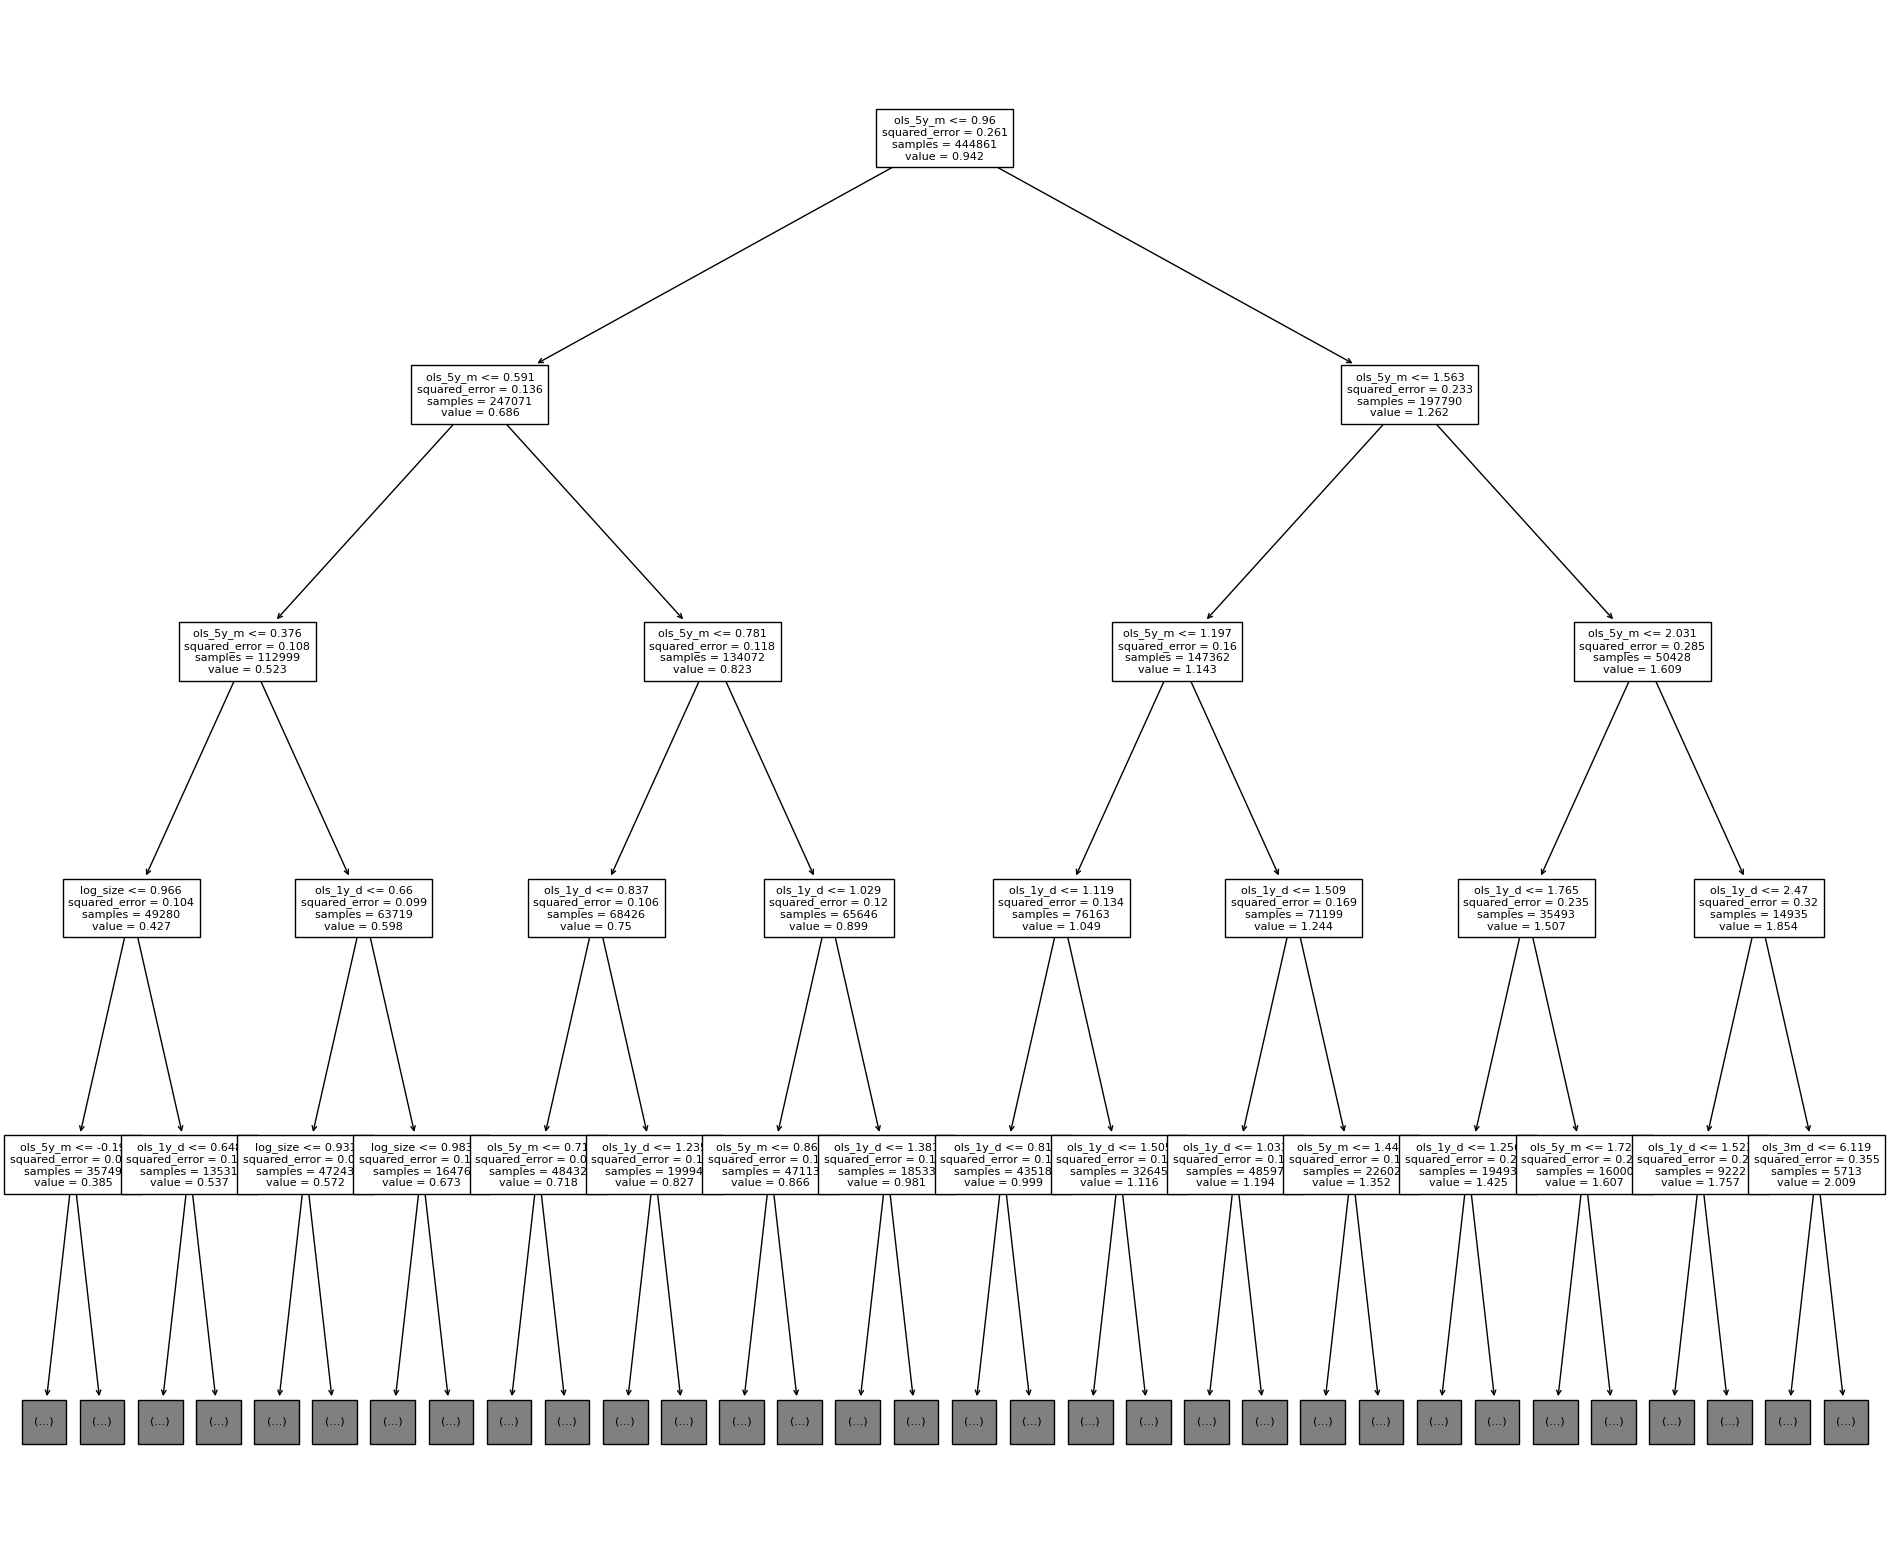

In [21]:
import matplotlib.pyplot as plt
from sklearn import tree

# Get one of the trees from the model
tree_index = 1  # Change this to the index of the tree you want to plot
tree_estimator = model.estimators_[tree_index]

plt.figure( figsize=(24,20) )
# Plot the tree
tree.plot_tree(tree_estimator, max_depth=4, feature_names=features_to_use, fontsize=8)
plt.show()


In [44]:
df_X_train_transformed.columns

Index(['winsorize__log_size', 'remainder__ols_3m_d', 'remainder__ols_1y_d',
       'remainder__ols_5y_m', 'remainder__log_age_lb'],
      dtype='object')

In [75]:

alpha = 0.0038129


beginning_oos = end_validation = datetime.date(2017, 2, 28)
end_oos = datetime.date(2022, 3, 31)
beginning_validation = beginning_oos - timedelta(days=365*2)

accounting_ratios = [
    'log_bm',
    'roa', 
    'roe',
    'log_pcf',
]
size_and_value = [
    'log_size',
    'log_age_lb', 
]
mom_reversal_vol = [
    'mom',
    'vol', 
    'price', 
    'strev', 
]

baselines = [
    'ols_3m_d', 
    'ols_1y_d',
    'ols_5y_m', 
]

market_features = [
    'rf', 
    'rm', 
    'market_cap',
    'capm_return'
]

include_accounting_ratios = False
include_size_and_value = False
include_mom_reversal_vol = True
include_market_features = False
append = False

features_to_use = baselines
if include_accounting_ratios:
    features_to_use += accounting_ratios
if include_size_and_value:
    features_to_use += size_and_value
if include_mom_reversal_vol:
    features_to_use += mom_reversal_vol
if include_market_features:
    features_to_use += market_features



zscore_level_features = False
features_to_zscore = []

if zscore_level_features:
    suggesed_features = ['log_bm', 'roa', 'roe', 'log_pcf', 'log_size', 'rm', 'rf', 'market_cap']
    features_to_zscore += [feature for feature in suggesed_features if feature in features_to_use]

winsorize = False
features_to_winsorize = []
if winsorize:
    suggesed_features = ['log_bm', 'roa', 'roe', 'log_pcf', 'log_size', 'rm', 'rf', 'market_cap', 'mom', 'vol', 'price', 'strev', 'capm_return']
    features_to_winsorize += [feature for feature in suggesed_features if feature in features_to_use]

for feature in features_to_use:
    if feature not in df.columns:
        print(f"Missing {feature}")
        break
    
preprocessor = ColumnTransformer([
    ('zscore', column_transforms.ZscoreTransformer(ewm_period_m=12, ewm_period_std_dev=30, append = append), features_to_zscore),   # Standardize numerical columns
    ('winsorize', column_transforms.Winsorizer(), features_to_winsorize),   # Winsorize numerical columns               
], remainder = 'passthrough')  

model = Lasso(alpha=alpha)

df_X_train = df.loc[:beginning_oos, features_to_use]
df_X_train_transformed = preprocessor.fit_transform(df_X_train)

df_y_train = df.loc[:beginning_oos, 'f_ols_1y_d']

model.fit(df_X_train_transformed, df_y_train)

# Get the forecast for beginning_validation to end_validation period
df_X_forecast = df.loc[beginning_oos:end_oos, features_to_use]
df_X_forecast_transformed = preprocessor.transform(df_X_forecast)
df['forecast'] = pd.Series(model.predict(df_X_forecast_transformed), index = df_X_forecast.index) # we don't need to reindex the forecast

wmape = utils.value_weighted_mape(df, 'forecast', 'f_ols_1y_d', beginning_oos, end_oos)
wmse = utils.value_weighted_mse(df, 'forecast', 'f_ols_1y_d', beginning_oos, end_oos)
mape = utils.simple_mape(df, 'forecast', 'f_ols_1y_d', beginning_oos, end_oos, )
mse = utils.simple_mse(df, 'forecast', 'f_ols_1y_d', beginning_oos, end_oos, )

print(f"WMSE: {wmse}")
print(f"WMAPE: {wmape}")
print(f"MSE: {mse}")
print(f"MAPE: {mape}")


WMSE: 0.08836329795979096
WMAPE: 29.684044766577482
MSE: 0.13491415619102598
MAPE: 34.000487097721575


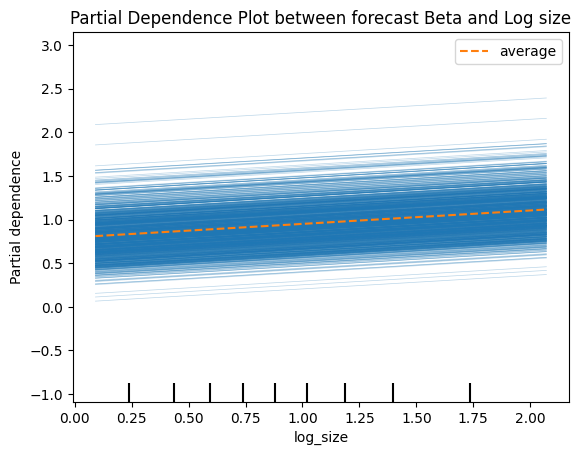

In [76]:
from sklearn.inspection import PartialDependenceDisplay

# Select the features for which you want to create the partial dependence plot
features = ['log_size', ]
display = PartialDependenceDisplay.from_estimator(model, df_X_train_transformed, features, feature_names = ['log_size'], kind='both', )
plt.title('Partial Dependence Plot between forecast Beta and Log size')

# Create the partial dependence plot
plt.show()


/var/folders/s_/_7wbxghn15vb26m1jpwf50km0000gn/T/ipykernel_71077/3166559100.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=50)
/var/folders/s_/_7wbxghn15vb26m1jpwf50km0000gn/T/ipykernel_71077/3166559100.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=50)


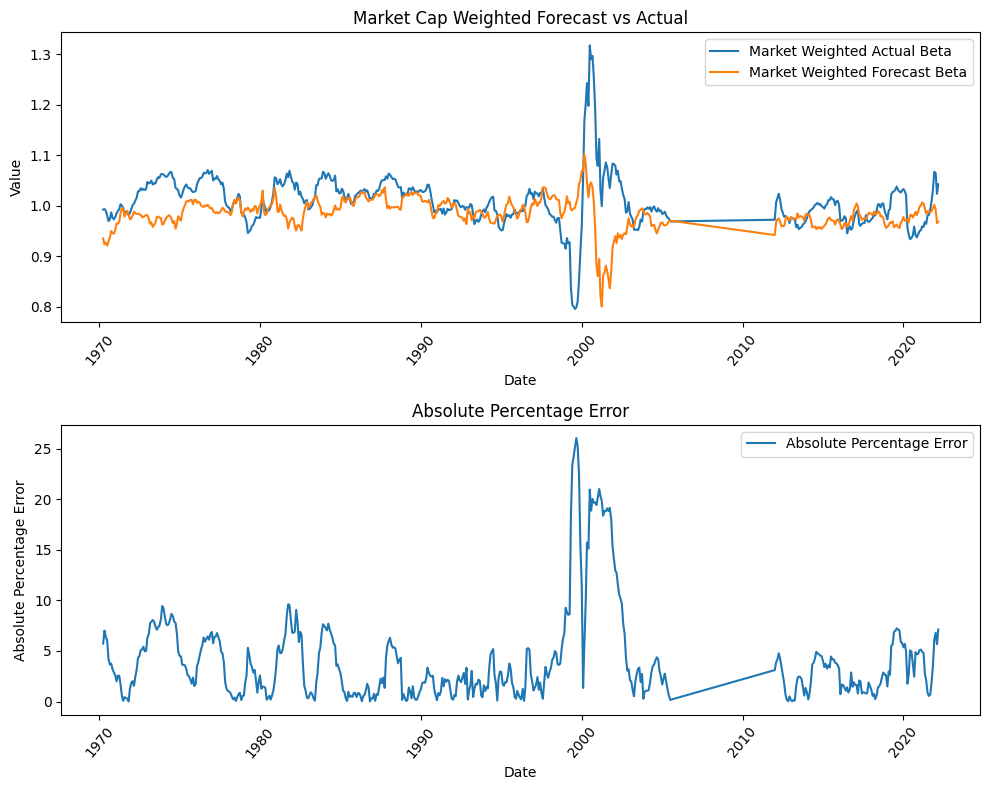

In [77]:
df_X_forecast = df.loc[:, features_to_use]
df_X_forecast_transformed = preprocessor.transform(df_X_forecast)
df['forecast'] = pd.Series(model.predict(df_X_forecast_transformed), index = df_X_forecast.index) # we don't need to reindex the forecast


# Group by date and calculate market cap weighted forecast and actual
df_grouped = df.groupby(level=0).apply(lambda x: pd.Series({
    'forecast': np.average(x['forecast'], weights=x['market_cap']),
    'actual': np.average(x['f_ols_1y_d'], weights=x['market_cap'])
}))

# Calculate absolute percentage error
df_grouped['abs_error'] = abs(df_grouped['forecast'] - df_grouped['actual']) / df_grouped['actual'] * 100

# Plot the subplot
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot market cap weighted forecast with actual
df_grouped['actual'].plot(ax=axes[0], label='Market Weighted Actual Beta')
df_grouped['forecast'].plot(ax=axes[0], label='Market Weighted Forecast Beta')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Value')
axes[0].legend()
axes[0].set_title('Market Cap Weighted Forecast vs Actual')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=50)

# Plot absolute percentage error
df_grouped['abs_error'].plot(ax=axes[1], label='Absolute Percentage Error')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Absolute Percentage Error')
axes[1].set_title('Absolute Percentage Error')
axes[1].legend()
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=50)

plt.tight_layout()
plt.show()


There's a lot of low hanging fruit around, things that would give a lot of points for low effort.

In [78]:
grouped_by_ticker = df.groupby(level=1).apply(lambda x: x['market_cap'].mean())
# Create quintiles
quintiles = pd.qcut(grouped_by_ticker, q=5, labels=False)
# quintiles
quintile_lists = [quintiles[quintiles == i].index.tolist() for i in range(5)]



In [79]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(time_series):
    if len(time_series) < 10:
        return True
    if time_series.min() == time_series.max():
        return True
    return adfuller(time_series)[1] < 0.05

fraction_stationary = []
for i, quintile in enumerate(quintile_lists):
    stat = 0
    total_num = 0
    for ticker in quintile:
        time_series = df.loc[(slice(None), ticker), 'forecast']
        if adfuller_test(time_series):
            stat += 1
        total_num += 1

    fraction_stationary.append(stat / total_num)

fraction_stationary


[0.36528685548293394,
 0.3851744186046512,
 0.3493100944081336,
 0.29578488372093026,
 0.32171387073347857]

In [80]:
from sklearn.linear_model import LinearRegression
def half_life(time_series):
    lag = time_series.shift(1)
    lag.iloc[0] = lag.iloc[1]
    regression = LinearRegression(fit_intercept=True)

    y = time_series.values.reshape(-1, 1)[1:]
    X = lag.values.reshape(-1, 1)[1:]

    regression.fit(X, y)
    coeff = regression.coef_[0][0]
    
    return np.log(2) / np.abs(coeff)

def valid_time_series(time_series):
    if len(time_series) < 10:
        return False
    if time_series.min() == time_series.max():
        return False
    return True

half_lives = []
for i, quintile in enumerate(quintile_lists):
    half_life_list = []
    for ticker in quintile:
        time_series = df.loc[(slice(None), ticker), 'f_ols_1y_d']
        if valid_time_series(time_series):
            half_life_list.append(half_life(time_series))
    half_lives.append(np.mean(half_life_list))

half_lives

[1.013708877553385,
 0.899869905718222,
 1.1373917748259992,
 0.8232515812828642,
 0.8139496500641795]

/var/folders/s_/_7wbxghn15vb26m1jpwf50km0000gn/T/ipykernel_71077/610115772.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(axes.get_xticklabels(), rotation=50)


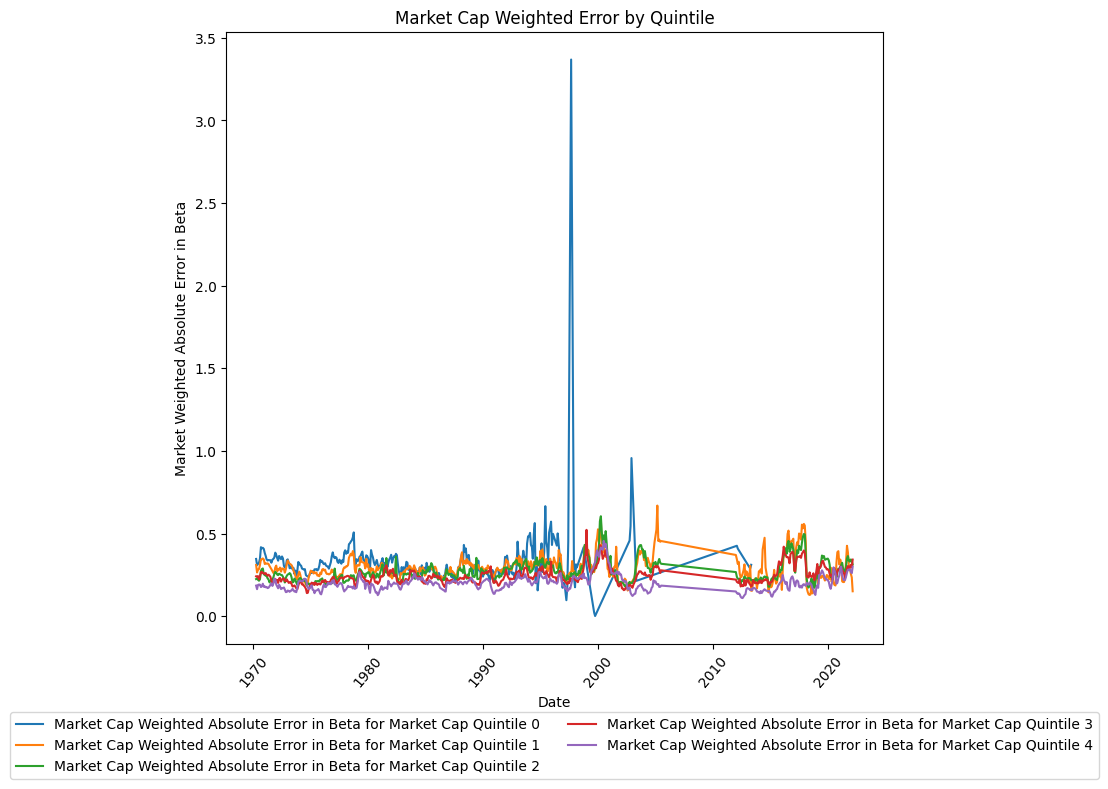

In [81]:
df_X_forecast = df.loc[:, features_to_use]
df_X_forecast_transformed = preprocessor.transform(df_X_forecast)
df['forecast'] = pd.Series(model.predict(df_X_forecast_transformed), index = df_X_forecast.index) # we don't need to reindex the forecast
df['abs error'] = pd.Series(abs(df['forecast'] - df['f_ols_1y_d']), index = df.index)

quintile_series_list = []
for quintile_list in quintile_lists:
    quintile_series = df.loc[pd.IndexSlice[:, quintile_list], :].groupby(level=0).apply(lambda x: np.average(x['abs error'], weights = x['market_cap']))
    quintile_series_list.append(quintile_series)

# Plot the subplot
fig, axes = plt.subplots(1, 1, figsize=(10, 8))

for i in range(5):
    quintile_series_list[i].plot(ax=axes, label=f'Market Cap Weighted Absolute Error in Beta for Market Cap Quintile {i}')

axes.set_xlabel('Date')
axes.set_ylabel('Market Weighted Absolute Error in Beta')
axes.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
axes.set_title('Market Cap Weighted Error by Quintile')
axes.set_xticklabels(axes.get_xticklabels(), rotation=50)

plt.tight_layout()
plt.show()
